# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

2024-02-26 23:38:45.660100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier

        if classifier == 'logreg':
            self.classifier = LogisticRegression()
        elif classifier == "svm":
            self.classifier = SVC(kernel="linear", probability=True)
        else:
            raise ValueError("Classifier not defined")
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
        
        n_subsample = int(1e3)
        subsample_ind = np.random.permutation(X.shape[0])[:n_subsample]
        X_sample = X[subsample_ind, :]
        sigma = np.sqrt(np.median(np.sum((X_sample[:, np.newaxis, :] - X_sample[np.newaxis, ...]) ** 2, axis=2)))

        self.w = np.random.normal(0, 1.0 / sigma, (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, (self.n_features))

        X_new_features = np.cos(X @ self.w + self.b[np.newaxis, :])

        self.classifier.fit(X_new_features, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = np.cos(X @ self.w + self.b[np.newaxis, :])
        y_proba = self.classifier.predict_proba(X)
        return y_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        y_proba = self.predict_proba(X)
        return y_proba.argmax(axis=1)

In [4]:
from sklearn.metrics import accuracy_score

rff = RFFPipeline()
rff.fit(x_train, y_train)
predictions = rff.predict(x_test)
acc = accuracy_score(y_test, predictions)
print(f"RFF accuracy: {acc}")

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF accuracy: 0.8597


Ура!

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {model_name}")

    acc_train = accuracy_score(y_train, model.predict(X_train))
    print(f"Train accuracy: {acc_train}")

    acc_test = accuracy_score(y_test, model.predict(X_test))
    print(f"Test accuracy: {acc_test}")

In [6]:
x_train.shape[0], x_test.shape[0]

(60000, 10000)

In [7]:
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_subsamples = 15000 # странно брать меньше теста
subsample_indicies = np.random.permutation(x_train.shape[0])[:n_subsamples]
x_train_sample = x_train[subsample_indicies, :]
y_train_sample = y_train[subsample_indicies]

# Без этого нет сходимости
scaler = StandardScaler()
x_train_sample = scaler.fit_transform(x_train_sample)
x_test_scaled = scaler.transform(x_test)

In [9]:
%%time

# SVM (линейный) на исходных
svm_linear = SVC(kernel="linear")
svm_linear.fit(x_train_sample, y_train_sample)

CPU times: user 40.4 s, sys: 209 ms, total: 40.6 s
Wall time: 41 s


SVC(kernel='linear')

In [10]:
evaluate_model(svm_linear, "SVM (linear)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating SVM (linear)
Train accuracy: 0.9730666666666666
Test accuracy: 0.81


In [12]:
%%time

# SVM (ядровой) на исходных
svm_rbf = SVC()
svm_rbf.fit(x_train_sample, y_train_sample)

CPU times: user 30.7 s, sys: 181 ms, total: 30.9 s
Wall time: 31.1 s


SVC()

In [13]:
evaluate_model(svm_rbf, "SVM (rbf)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating SVM (rbf)
Train accuracy: 0.9171333333333334
Test accuracy: 0.8609


In [15]:
%%time

# RFF
rff_logreg = RFFPipeline()
rff_logreg.fit(x_train_sample, y_train_sample)

CPU times: user 27 s, sys: 10.1 s, total: 37.1 s
Wall time: 6.47 s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline(classifier=LogisticRegression())

In [16]:
evaluate_model(rff_logreg, "RFF (logistic regression)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating RFF (logistic regression)
Train accuracy: 0.8822666666666666
Test accuracy: 0.8482


In [19]:
%%time

# RFF
rff_svm = RFFPipeline(classifier="svm")
rff_svm.fit(x_train_sample, y_train_sample)

CPU times: user 2min 9s, sys: 3.43 s, total: 2min 12s
Wall time: 2min 6s


RFFPipeline(classifier=SVC(kernel='linear', probability=True))

In [20]:
evaluate_model(rff_svm, "RFF (svm)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating RFF (svm)
Train accuracy: 0.9441333333333334
Test accuracy: 0.8611


In [6]:
%%time

# RFF
rff_logreg_full = RFFPipeline()
rff_logreg_full.fit(x_train, y_train)

CPU times: user 1min 54s, sys: 30 s, total: 2min 24s
Wall time: 20 s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline(classifier=LogisticRegression())

In [9]:
evaluate_model(rff_logreg_full, "RFF (logreg, all train samples)", x_train, y_train, x_test, y_test)

Evaluating RFF (logreg, all train samples)
Train accuracy: 0.8747333333333334
Test accuracy: 0.8604


In [8]:
from sklearn.model_selection import train_test_split

x_train_cb, x_val_cb, y_train_cb, y_val_cb = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

pca_catboost = PCA(n_components=50)

x_train_cb = pca_catboost.fit_transform(x_train_cb)
x_val_cb = pca_catboost.transform(x_val_cb)
x_test_cb = pca_catboost.transform(x_test)


In [22]:
import optuna
from catboost import CatBoostClassifier

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.

    # Boosting hyperparameters
    num_trees =  trial.suggest_int('num_trees', 1, 100, step=5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    classifier_obj = CatBoostClassifier(num_trees=num_trees, 
                                        learning_rate=learning_rate,
                                        loss_function='MultiClass')
    
    classifier_obj.fit(x_train_cb, y_train_cb, eval_set=(x_val_cb, y_val_cb))
    score = classifier_obj.score(x_val_cb, y_val_cb)
    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2024-02-26 23:51:20,577] A new study created in memory with name: no-name-5e205766-0a31-4184-aece-938f72eebc5e
/usr/local/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 100] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 96].
  warnings.warn(


0:	learn: 2.2999544	test: 2.2999756	best: 2.2999756 (0)	total: 70ms	remaining: 2.1s
1:	learn: 2.2974878	test: 2.2975161	best: 2.2975161 (1)	total: 137ms	remaining: 1.99s
2:	learn: 2.2949608	test: 2.2950007	best: 2.2950007 (2)	total: 224ms	remaining: 2.09s
3:	learn: 2.2922753	test: 2.2923394	best: 2.2923394 (3)	total: 318ms	remaining: 2.15s
4:	learn: 2.2896650	test: 2.2897389	best: 2.2897389 (4)	total: 417ms	remaining: 2.17s
5:	learn: 2.2870506	test: 2.2871401	best: 2.2871401 (5)	total: 551ms	remaining: 2.3s
6:	learn: 2.2845253	test: 2.2846327	best: 2.2846327 (6)	total: 609ms	remaining: 2.09s
7:	learn: 2.2820157	test: 2.2821251	best: 2.2821251 (7)	total: 664ms	remaining: 1.91s
8:	learn: 2.2793587	test: 2.2794845	best: 2.2794845 (8)	total: 718ms	remaining: 1.75s
9:	learn: 2.2768639	test: 2.2770002	best: 2.2770002 (9)	total: 778ms	remaining: 1.63s
10:	learn: 2.2743336	test: 2.2744883	best: 2.2744883 (10)	total: 840ms	remaining: 1.53s
11:	learn: 2.2718697	test: 2.2720287	best: 2.2720287 (1

[I 2024-02-26 23:51:24,035] Trial 0 finished with value: 0.6515 and parameters: {'num_trees': 31, 'learning_rate': 0.0007054791428580866}. Best is trial 0 with value: 0.6515.


0:	learn: 2.2684551	test: 2.2687307	best: 2.2687307 (0)	total: 58.1ms	remaining: 2.61s
1:	learn: 2.2380029	test: 2.2383722	best: 2.2383722 (1)	total: 113ms	remaining: 2.48s
2:	learn: 2.2090289	test: 2.2094515	best: 2.2094515 (2)	total: 166ms	remaining: 2.38s
3:	learn: 2.1785804	test: 2.1792893	best: 2.1792893 (3)	total: 221ms	remaining: 2.32s
4:	learn: 2.1516467	test: 2.1525302	best: 2.1525302 (4)	total: 274ms	remaining: 2.25s
5:	learn: 2.1245002	test: 2.1255731	best: 2.1255731 (5)	total: 330ms	remaining: 2.2s
6:	learn: 2.0993442	test: 2.1006207	best: 2.1006207 (6)	total: 384ms	remaining: 2.14s
7:	learn: 2.0762132	test: 2.0775582	best: 2.0775582 (7)	total: 438ms	remaining: 2.08s
8:	learn: 2.0511845	test: 2.0526998	best: 2.0526998 (8)	total: 493ms	remaining: 2.02s
9:	learn: 2.0286700	test: 2.0303028	best: 2.0303028 (9)	total: 547ms	remaining: 1.97s
10:	learn: 2.0069093	test: 2.0087261	best: 2.0087261 (10)	total: 602ms	remaining: 1.92s
11:	learn: 1.9858643	test: 1.9877345	best: 1.9877345

[I 2024-02-26 23:51:28,179] Trial 1 finished with value: 0.6758888888888889 and parameters: {'num_trees': 46, 'learning_rate': 0.009191656850520742}. Best is trial 0 with value: 0.6515.


0:	learn: 2.2851560	test: 2.2852965	best: 2.2852965 (0)	total: 54.2ms	remaining: 4.34s
1:	learn: 2.2691899	test: 2.2693778	best: 2.2693778 (1)	total: 112ms	remaining: 4.44s
2:	learn: 2.2531843	test: 2.2534484	best: 2.2534484 (2)	total: 171ms	remaining: 4.45s
3:	learn: 2.2365163	test: 2.2369335	best: 2.2369335 (3)	total: 227ms	remaining: 4.38s
4:	learn: 2.2214039	test: 2.2219113	best: 2.2219113 (4)	total: 285ms	remaining: 4.33s
5:	learn: 2.2058837	test: 2.2064924	best: 2.2064924 (5)	total: 342ms	remaining: 4.27s
6:	learn: 2.1911890	test: 2.1919090	best: 2.1919090 (6)	total: 397ms	remaining: 4.2s
7:	learn: 2.1774614	test: 2.1782117	best: 2.1782117 (7)	total: 455ms	remaining: 4.15s
8:	learn: 2.1624927	test: 2.1633412	best: 2.1633412 (8)	total: 511ms	remaining: 4.09s
9:	learn: 2.1487463	test: 2.1496609	best: 2.1496609 (9)	total: 568ms	remaining: 4.04s
10:	learn: 2.1351758	test: 2.1361982	best: 2.1361982 (10)	total: 624ms	remaining: 3.97s
11:	learn: 2.1220551	test: 2.1231028	best: 2.1231028

[I 2024-02-26 23:51:35,084] Trial 2 finished with value: 0.6806111111111111 and parameters: {'num_trees': 81, 'learning_rate': 0.0046832501855230664}. Best is trial 0 with value: 0.6515.


0:	learn: 2.2987546	test: 2.2987855	best: 2.2987855 (0)	total: 131ms	remaining: 1.31s
1:	learn: 2.2951698	test: 2.2952109	best: 2.2952109 (1)	total: 229ms	remaining: 1.03s
2:	learn: 2.2915037	test: 2.2915619	best: 2.2915619 (2)	total: 293ms	remaining: 780ms
3:	learn: 2.2876145	test: 2.2877076	best: 2.2877076 (3)	total: 349ms	remaining: 611ms
4:	learn: 2.2838425	test: 2.2839499	best: 2.2839499 (4)	total: 406ms	remaining: 488ms
5:	learn: 2.2800715	test: 2.2802018	best: 2.2802018 (5)	total: 461ms	remaining: 384ms
6:	learn: 2.2764353	test: 2.2765914	best: 2.2765914 (6)	total: 517ms	remaining: 295ms
7:	learn: 2.2728277	test: 2.2729869	best: 2.2729869 (7)	total: 578ms	remaining: 217ms
8:	learn: 2.2690138	test: 2.2691966	best: 2.2691966 (8)	total: 654ms	remaining: 145ms
9:	learn: 2.2654409	test: 2.2656389	best: 2.2656389 (9)	total: 755ms	remaining: 75.5ms
10:	learn: 2.2618258	test: 2.2620504	best: 2.2620504 (10)	total: 855ms	remaining: 0us

bestTest = 2.262050419
bestIteration = 10



[I 2024-02-26 23:51:37,265] Trial 3 finished with value: 0.6489444444444444 and parameters: {'num_trees': 11, 'learning_rate': 0.001027401563612028}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.0209681	test: 2.0233018	best: 2.0233018 (0)	total: 83.5ms	remaining: 5.84s
1:	learn: 1.8522390	test: 1.8552966	best: 1.8552966 (1)	total: 179ms	remaining: 6.17s
2:	learn: 1.7260156	test: 1.7293145	best: 1.7293145 (2)	total: 268ms	remaining: 6.08s
3:	learn: 1.6127703	test: 1.6173159	best: 1.6173159 (3)	total: 332ms	remaining: 5.56s
4:	learn: 1.5196834	test: 1.5253027	best: 1.5253027 (4)	total: 389ms	remaining: 5.13s
5:	learn: 1.4434438	test: 1.4497269	best: 1.4497269 (5)	total: 443ms	remaining: 4.8s
6:	learn: 1.3717608	test: 1.3784458	best: 1.3784458 (6)	total: 503ms	remaining: 4.6s
7:	learn: 1.3128545	test: 1.3193463	best: 1.3193463 (7)	total: 572ms	remaining: 4.5s
8:	learn: 1.2609326	test: 1.2678973	best: 1.2678973 (8)	total: 647ms	remaining: 4.46s
9:	learn: 1.2090536	test: 1.2159530	best: 1.2159530 (9)	total: 723ms	remaining: 4.41s
10:	learn: 1.1672736	test: 1.1740931	best: 1.1740931 (10)	total: 788ms	remaining: 4.3s
11:	learn: 1.1263835	test: 1.1330004	best: 1.1330004 (1

[I 2024-02-26 23:51:43,901] Trial 4 finished with value: 0.8178333333333333 and parameters: {'num_trees': 71, 'learning_rate': 0.07900438337931201}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.3024583	test: 2.3024593	best: 2.3024593 (0)	total: 106ms	remaining: 3.71s
1:	learn: 2.3023389	test: 2.3023403	best: 2.3023403 (1)	total: 256ms	remaining: 4.36s
2:	learn: 2.3022161	test: 2.3022181	best: 2.3022181 (2)	total: 354ms	remaining: 3.9s
3:	learn: 2.3020852	test: 2.3020883	best: 2.3020883 (3)	total: 444ms	remaining: 3.55s
4:	learn: 2.3019573	test: 2.3019609	best: 2.3019609 (4)	total: 517ms	remaining: 3.2s
5:	learn: 2.3018287	test: 2.3018331	best: 2.3018331 (5)	total: 583ms	remaining: 2.91s
6:	learn: 2.3017041	test: 2.3017093	best: 2.3017093 (6)	total: 657ms	remaining: 2.72s
7:	learn: 2.3015798	test: 2.3015850	best: 2.3015850 (7)	total: 730ms	remaining: 2.56s
8:	learn: 2.3014477	test: 2.3014538	best: 2.3014538 (8)	total: 796ms	remaining: 2.39s
9:	learn: 2.3013231	test: 2.3013297	best: 2.3013297 (9)	total: 860ms	remaining: 2.23s
10:	learn: 2.3011961	test: 2.3012036	best: 2.3012036 (10)	total: 920ms	remaining: 2.09s
11:	learn: 2.3010722	test: 2.3010798	best: 2.3010798 (

[I 2024-02-26 23:51:48,007] Trial 5 finished with value: 0.6506666666666666 and parameters: {'num_trees': 36, 'learning_rate': 3.3998540482411636e-05}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.3021598	test: 2.3021632	best: 2.3021632 (0)	total: 76.2ms	remaining: 6.48s
1:	learn: 2.3017596	test: 2.3017642	best: 2.3017642 (1)	total: 157ms	remaining: 6.61s
2:	learn: 2.3013483	test: 2.3013548	best: 2.3013548 (2)	total: 230ms	remaining: 6.37s
3:	learn: 2.3009098	test: 2.3009202	best: 2.3009202 (3)	total: 294ms	remaining: 6.02s
4:	learn: 2.3004818	test: 2.3004938	best: 2.3004938 (4)	total: 359ms	remaining: 5.82s
5:	learn: 2.3000516	test: 2.3000661	best: 2.3000661 (5)	total: 430ms	remaining: 5.74s
6:	learn: 2.2996348	test: 2.2996522	best: 2.2996522 (6)	total: 496ms	remaining: 5.6s
7:	learn: 2.2992192	test: 2.2992369	best: 2.2992369 (7)	total: 567ms	remaining: 5.53s
8:	learn: 2.2987780	test: 2.2987984	best: 2.2987984 (8)	total: 637ms	remaining: 5.45s
9:	learn: 2.2983619	test: 2.2983840	best: 2.2983840 (9)	total: 702ms	remaining: 5.33s
10:	learn: 2.2979380	test: 2.2979631	best: 2.2979631 (10)	total: 763ms	remaining: 5.2s
11:	learn: 2.2975245	test: 2.2975503	best: 2.2975503 

[I 2024-02-26 23:51:55,086] Trial 6 finished with value: 0.6556111111111111 and parameters: {'num_trees': 86, 'learning_rate': 0.00011402145732393478}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.3010905	test: 2.3011025	best: 2.3011025 (0)	total: 71ms	remaining: 6.75s
1:	learn: 2.2996866	test: 2.2997026	best: 2.2997026 (1)	total: 134ms	remaining: 6.28s
2:	learn: 2.2982459	test: 2.2982686	best: 2.2982686 (2)	total: 205ms	remaining: 6.35s
3:	learn: 2.2967123	test: 2.2967487	best: 2.2967487 (3)	total: 286ms	remaining: 6.58s
4:	learn: 2.2952185	test: 2.2952605	best: 2.2952605 (4)	total: 344ms	remaining: 6.27s
5:	learn: 2.2937196	test: 2.2937705	best: 2.2937705 (5)	total: 400ms	remaining: 5.99s
6:	learn: 2.2922696	test: 2.2923307	best: 2.2923307 (6)	total: 472ms	remaining: 6s
7:	learn: 2.2908261	test: 2.2908883	best: 2.2908883 (7)	total: 540ms	remaining: 5.94s
8:	learn: 2.2892957	test: 2.2893673	best: 2.2893673 (8)	total: 596ms	remaining: 5.76s
9:	learn: 2.2878555	test: 2.2879331	best: 2.2879331 (9)	total: 649ms	remaining: 5.58s
10:	learn: 2.2863914	test: 2.2864796	best: 2.2864796 (10)	total: 707ms	remaining: 5.46s
11:	learn: 2.2849648	test: 2.2850552	best: 2.2850552 (11

[I 2024-02-26 23:52:03,189] Trial 7 finished with value: 0.6585 and parameters: {'num_trees': 96, 'learning_rate': 0.00040075398004878416}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.2038453	test: 2.2046472	best: 2.2046472 (0)	total: 104ms	remaining: 2.08s
1:	learn: 2.1243350	test: 2.1254130	best: 2.1254130 (1)	total: 202ms	remaining: 1.92s
2:	learn: 2.0546192	test: 2.0558428	best: 2.0558428 (2)	total: 265ms	remaining: 1.59s
3:	learn: 1.9856434	test: 1.9875560	best: 1.9875560 (3)	total: 348ms	remaining: 1.48s
4:	learn: 1.9287382	test: 1.9310938	best: 1.9310938 (4)	total: 427ms	remaining: 1.37s
5:	learn: 1.8764119	test: 1.8792311	best: 1.8792311 (5)	total: 498ms	remaining: 1.24s
6:	learn: 1.8285170	test: 1.8317814	best: 1.8317814 (6)	total: 563ms	remaining: 1.13s
7:	learn: 1.7828784	test: 1.7862871	best: 1.7862871 (7)	total: 630ms	remaining: 1.02s
8:	learn: 1.7381063	test: 1.7418227	best: 1.7418227 (8)	total: 695ms	remaining: 927ms
9:	learn: 1.6998989	test: 1.7036530	best: 1.7036530 (9)	total: 777ms	remaining: 854ms
10:	learn: 1.6646309	test: 1.6685274	best: 1.6685274 (10)	total: 850ms	remaining: 772ms
11:	learn: 1.6267270	test: 1.6308441	best: 1.6308441

[I 2024-02-26 23:52:05,964] Trial 8 finished with value: 0.6867222222222222 and parameters: {'num_trees': 21, 'learning_rate': 0.02683980776520276}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.2541100	test: 2.2545019	best: 2.2545019 (0)	total: 102ms	remaining: 7.67s
1:	learn: 2.2118286	test: 2.2123545	best: 2.2123545 (1)	total: 190ms	remaining: 7.04s
2:	learn: 2.1723811	test: 2.1729825	best: 2.1729825 (2)	total: 279ms	remaining: 6.78s
3:	learn: 2.1315574	test: 2.1325490	best: 2.1325490 (3)	total: 364ms	remaining: 6.56s
4:	learn: 2.0960968	test: 2.0973309	best: 2.0973309 (4)	total: 462ms	remaining: 6.56s
5:	learn: 2.0623960	test: 2.0639026	best: 2.0639026 (5)	total: 554ms	remaining: 6.46s
6:	learn: 2.0302073	test: 2.0319870	best: 2.0319870 (6)	total: 634ms	remaining: 6.25s
7:	learn: 1.9989140	test: 2.0007845	best: 2.0007845 (7)	total: 707ms	remaining: 6.01s
8:	learn: 1.9674610	test: 1.9695471	best: 1.9695471 (8)	total: 802ms	remaining: 5.97s
9:	learn: 1.9399009	test: 1.9421909	best: 1.9421909 (9)	total: 898ms	remaining: 5.93s
10:	learn: 1.9132456	test: 1.9157673	best: 1.9157673 (10)	total: 993ms	remaining: 5.87s
11:	learn: 1.8874845	test: 1.8900798	best: 1.8900798

[I 2024-02-26 23:52:13,091] Trial 9 finished with value: 0.7142777777777778 and parameters: {'num_trees': 76, 'learning_rate': 0.01308098248679543}. Best is trial 3 with value: 0.6489444444444444.


0:	learn: 2.3025329	test: 2.3025333	best: 2.3025333 (0)	total: 53ms	remaining: 0us

bestTest = 2.302533336
bestIteration = 0



[I 2024-02-26 23:52:14,310] Trial 10 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 1.3987806508730453e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025259	test: 2.3025263	best: 2.3025263 (0)	total: 58.6ms	remaining: 0us

bestTest = 2.302526333
bestIteration = 0



[I 2024-02-26 23:52:15,489] Trial 11 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 1.5880623076232577e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025423	test: 2.3025426	best: 2.3025426 (0)	total: 59.5ms	remaining: 298ms
1:	learn: 2.3025020	test: 2.3025024	best: 2.3025024 (1)	total: 131ms	remaining: 262ms
2:	learn: 2.3024605	test: 2.3024612	best: 2.3024612 (2)	total: 204ms	remaining: 204ms
3:	learn: 2.3024163	test: 2.3024173	best: 2.3024173 (3)	total: 273ms	remaining: 136ms
4:	learn: 2.3023731	test: 2.3023743	best: 2.3023743 (4)	total: 337ms	remaining: 67.4ms
5:	learn: 2.3023296	test: 2.3023311	best: 2.3023311 (5)	total: 400ms	remaining: 0us

bestTest = 2.302331093
bestIteration = 5



[I 2024-02-26 23:52:17,047] Trial 12 finished with value: 0.6442777777777777 and parameters: {'num_trees': 6, 'learning_rate': 1.1479194931430765e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025471	test: 2.3025474	best: 2.3025474 (0)	total: 60.2ms	remaining: 0us

bestTest = 2.302547401
bestIteration = 0



[I 2024-02-26 23:52:18,197] Trial 13 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 1.0186664337852359e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3023545	test: 2.3023564	best: 2.3023564 (0)	total: 60.1ms	remaining: 1.2s
1:	learn: 2.3021375	test: 2.3021400	best: 2.3021400 (1)	total: 124ms	remaining: 1.18s
2:	learn: 2.3019144	test: 2.3019179	best: 2.3019179 (2)	total: 196ms	remaining: 1.17s
3:	learn: 2.3016764	test: 2.3016820	best: 2.3016820 (3)	total: 254ms	remaining: 1.08s
4:	learn: 2.3014441	test: 2.3014506	best: 2.3014506 (4)	total: 326ms	remaining: 1.04s
5:	learn: 2.3012105	test: 2.3012184	best: 2.3012184 (5)	total: 393ms	remaining: 982ms
6:	learn: 2.3009841	test: 2.3009935	best: 2.3009935 (6)	total: 449ms	remaining: 898ms
7:	learn: 2.3007583	test: 2.3007679	best: 2.3007679 (7)	total: 502ms	remaining: 815ms
8:	learn: 2.3005185	test: 2.3005296	best: 2.3005296 (8)	total: 608ms	remaining: 811ms
9:	learn: 2.3002923	test: 2.3003043	best: 2.3003043 (9)	total: 674ms	remaining: 741ms
10:	learn: 2.3000617	test: 2.3000753	best: 2.3000753 (10)	total: 730ms	remaining: 663ms
11:	learn: 2.2998368	test: 2.2998508	best: 2.2998508

[I 2024-02-26 23:52:20,716] Trial 14 finished with value: 0.6495555555555556 and parameters: {'num_trees': 21, 'learning_rate': 6.181569085894685e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3020972	test: 2.3021012	best: 2.3021012 (0)	total: 90.4ms	remaining: 5.42s
1:	learn: 2.3016383	test: 2.3016435	best: 2.3016435 (1)	total: 195ms	remaining: 5.74s
2:	learn: 2.3011665	test: 2.3011739	best: 2.3011739 (2)	total: 275ms	remaining: 5.31s
3:	learn: 2.3006636	test: 2.3006755	best: 2.3006755 (3)	total: 352ms	remaining: 5.02s
4:	learn: 2.3001729	test: 2.3001866	best: 2.3001866 (4)	total: 418ms	remaining: 4.68s
5:	learn: 2.2996796	test: 2.2996963	best: 2.2996963 (5)	total: 473ms	remaining: 4.33s
6:	learn: 2.2992018	test: 2.2992218	best: 2.2992218 (6)	total: 527ms	remaining: 4.07s
7:	learn: 2.2987254	test: 2.2987457	best: 2.2987457 (7)	total: 583ms	remaining: 3.86s
8:	learn: 2.2982197	test: 2.2982431	best: 2.2982431 (8)	total: 638ms	remaining: 3.69s
9:	learn: 2.2977428	test: 2.2977682	best: 2.2977682 (9)	total: 691ms	remaining: 3.52s
10:	learn: 2.2972570	test: 2.2972858	best: 2.2972858 (10)	total: 748ms	remaining: 3.4s
11:	learn: 2.2967833	test: 2.2968128	best: 2.2968128

[I 2024-02-26 23:52:26,045] Trial 15 finished with value: 0.6528888888888889 and parameters: {'num_trees': 61, 'learning_rate': 0.00013079582022687441}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3024865	test: 2.3024873	best: 2.3024873 (0)	total: 92.2ms	remaining: 1.38s
1:	learn: 2.3023938	test: 2.3023948	best: 2.3023948 (1)	total: 193ms	remaining: 1.35s
2:	learn: 2.3022984	test: 2.3022999	best: 2.3022999 (2)	total: 283ms	remaining: 1.23s
3:	learn: 2.3021966	test: 2.3021990	best: 2.3021990 (3)	total: 363ms	remaining: 1.09s
4:	learn: 2.3020972	test: 2.3021000	best: 2.3021000 (4)	total: 426ms	remaining: 937ms
5:	learn: 2.3019973	test: 2.3020007	best: 2.3020007 (5)	total: 483ms	remaining: 805ms
6:	learn: 2.3019004	test: 2.3019045	best: 2.3019045 (6)	total: 541ms	remaining: 695ms
7:	learn: 2.3018038	test: 2.3018079	best: 2.3018079 (7)	total: 668ms	remaining: 668ms
8:	learn: 2.3017011	test: 2.3017059	best: 2.3017059 (8)	total: 723ms	remaining: 562ms
9:	learn: 2.3016043	test: 2.3016094	best: 2.3016094 (9)	total: 783ms	remaining: 470ms
10:	learn: 2.3015055	test: 2.3015113	best: 2.3015113 (10)	total: 843ms	remaining: 383ms
11:	learn: 2.3014092	test: 2.3014152	best: 2.301415

[I 2024-02-26 23:52:28,340] Trial 16 finished with value: 0.6478888888888888 and parameters: {'num_trees': 16, 'learning_rate': 2.6418248503985778e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3017732	test: 2.3017797	best: 2.3017797 (0)	total: 50.5ms	remaining: 0us

bestTest = 2.301779726
bestIteration = 0



[I 2024-02-26 23:52:29,399] Trial 17 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 0.00021768075763442952}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.2936801	test: 2.2937519	best: 2.2937519 (0)	total: 71.7ms	remaining: 2.15s
1:	learn: 2.2854125	test: 2.2855083	best: 2.2855083 (1)	total: 136ms	remaining: 1.97s
2:	learn: 2.2770209	test: 2.2771561	best: 2.2771561 (2)	total: 244ms	remaining: 2.28s
3:	learn: 2.2681815	test: 2.2683969	best: 2.2683969 (3)	total: 323ms	remaining: 2.18s
4:	learn: 2.2596865	test: 2.2599351	best: 2.2599351 (4)	total: 399ms	remaining: 2.08s
5:	learn: 2.2512585	test: 2.2515596	best: 2.2515596 (5)	total: 465ms	remaining: 1.94s
6:	learn: 2.2431849	test: 2.2435448	best: 2.2435448 (6)	total: 529ms	remaining: 1.81s
7:	learn: 2.2355444	test: 2.2359176	best: 2.2359176 (7)	total: 593ms	remaining: 1.7s
8:	learn: 2.2271760	test: 2.2276024	best: 2.2276024 (8)	total: 657ms	remaining: 1.6s
9:	learn: 2.2194034	test: 2.2198646	best: 2.2198646 (9)	total: 719ms	remaining: 1.51s
10:	learn: 2.2116204	test: 2.2121406	best: 2.2121406 (10)	total: 807ms	remaining: 1.47s
11:	learn: 2.2040901	test: 2.2046215	best: 2.2046215 

[I 2024-02-26 23:52:32,406] Trial 18 finished with value: 0.6598888888888889 and parameters: {'num_trees': 31, 'learning_rate': 0.0023900714763212603}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3024675	test: 2.3024684	best: 2.3024684 (0)	total: 74.7ms	remaining: 4.11s
1:	learn: 2.3023568	test: 2.3023581	best: 2.3023581 (1)	total: 153ms	remaining: 4.12s
2:	learn: 2.3022430	test: 2.3022448	best: 2.3022448 (2)	total: 236ms	remaining: 4.17s
3:	learn: 2.3021216	test: 2.3021244	best: 2.3021244 (3)	total: 341ms	remaining: 4.44s
4:	learn: 2.3020030	test: 2.3020063	best: 2.3020063 (4)	total: 439ms	remaining: 4.48s
5:	learn: 2.3018838	test: 2.3018878	best: 2.3018878 (5)	total: 564ms	remaining: 4.7s
6:	learn: 2.3017682	test: 2.3017730	best: 2.3017730 (6)	total: 641ms	remaining: 4.48s
7:	learn: 2.3016529	test: 2.3016578	best: 2.3016578 (7)	total: 752ms	remaining: 4.51s
8:	learn: 2.3015304	test: 2.3015361	best: 2.3015361 (8)	total: 883ms	remaining: 4.61s
9:	learn: 2.3014149	test: 2.3014210	best: 2.3014210 (9)	total: 971ms	remaining: 4.47s
10:	learn: 2.3012971	test: 2.3013040	best: 2.3013040 (10)	total: 1.08s	remaining: 4.42s
11:	learn: 2.3011821	test: 2.3011893	best: 2.3011893

[I 2024-02-26 23:52:37,633] Trial 19 finished with value: 0.6518333333333334 and parameters: {'num_trees': 56, 'learning_rate': 3.1524370215396295e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3023337	test: 2.3023357	best: 2.3023357 (0)	total: 51.8ms	remaining: 2.07s
1:	learn: 2.3020970	test: 2.3020997	best: 2.3020997 (1)	total: 108ms	remaining: 2.11s
2:	learn: 2.3018537	test: 2.3018576	best: 2.3018576 (2)	total: 164ms	remaining: 2.08s
3:	learn: 2.3015943	test: 2.3016004	best: 2.3016004 (3)	total: 221ms	remaining: 2.04s
4:	learn: 2.3013410	test: 2.3013481	best: 2.3013481 (4)	total: 278ms	remaining: 2s
5:	learn: 2.3010863	test: 2.3010949	best: 2.3010949 (5)	total: 336ms	remaining: 1.96s
6:	learn: 2.3008395	test: 2.3008498	best: 2.3008498 (6)	total: 391ms	remaining: 1.9s
7:	learn: 2.3005933	test: 2.3006038	best: 2.3006038 (7)	total: 446ms	remaining: 1.84s
8:	learn: 2.3003319	test: 2.3003440	best: 2.3003440 (8)	total: 504ms	remaining: 1.79s
9:	learn: 2.3000854	test: 2.3000984	best: 2.3000984 (9)	total: 561ms	remaining: 1.74s
10:	learn: 2.2998340	test: 2.2998489	best: 2.2998489 (10)	total: 617ms	remaining: 1.68s
11:	learn: 2.2995889	test: 2.2996041	best: 2.2996041 (1

[I 2024-02-26 23:52:41,034] Trial 20 finished with value: 0.6527222222222222 and parameters: {'num_trees': 41, 'learning_rate': 6.74054601921139e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025476	test: 2.3025479	best: 2.3025479 (0)	total: 54.9ms	remaining: 0us

bestTest = 2.302547908
bestIteration = 0



[I 2024-02-26 23:52:42,058] Trial 21 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 1.004951789555317e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025314	test: 2.3025318	best: 2.3025318 (0)	total: 95.5ms	remaining: 955ms
1:	learn: 2.3024809	test: 2.3024815	best: 2.3024815 (1)	total: 205ms	remaining: 921ms
2:	learn: 2.3024289	test: 2.3024297	best: 2.3024297 (2)	total: 303ms	remaining: 809ms
3:	learn: 2.3023735	test: 2.3023748	best: 2.3023748 (3)	total: 404ms	remaining: 707ms
4:	learn: 2.3023193	test: 2.3023208	best: 2.3023208 (4)	total: 524ms	remaining: 628ms
5:	learn: 2.3022649	test: 2.3022667	best: 2.3022667 (5)	total: 628ms	remaining: 524ms
6:	learn: 2.3022121	test: 2.3022143	best: 2.3022143 (6)	total: 728ms	remaining: 416ms
7:	learn: 2.3021594	test: 2.3021616	best: 2.3021616 (7)	total: 814ms	remaining: 305ms
8:	learn: 2.3021035	test: 2.3021060	best: 2.3021060 (8)	total: 896ms	remaining: 199ms
9:	learn: 2.3020507	test: 2.3020535	best: 2.3020535 (9)	total: 978ms	remaining: 97.8ms
10:	learn: 2.3019968	test: 2.3020000	best: 2.3020000 (10)	total: 1.07s	remaining: 0us

bestTest = 2.302000005
bestIteration = 10



[I 2024-02-26 23:52:44,296] Trial 22 finished with value: 0.6488333333333334 and parameters: {'num_trees': 11, 'learning_rate': 1.4390118670783977e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025002	test: 2.3025008	best: 2.3025008 (0)	total: 70.6ms	remaining: 0us

bestTest = 2.302500836
bestIteration = 0



[I 2024-02-26 23:52:45,610] Trial 23 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 2.2771487833547127e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3023944	test: 2.3023959	best: 2.3023959 (0)	total: 56.7ms	remaining: 1.13s
1:	learn: 2.3022148	test: 2.3022169	best: 2.3022169 (1)	total: 119ms	remaining: 1.13s
2:	learn: 2.3020302	test: 2.3020331	best: 2.3020331 (2)	total: 185ms	remaining: 1.11s
3:	learn: 2.3018333	test: 2.3018380	best: 2.3018380 (3)	total: 253ms	remaining: 1.07s
4:	learn: 2.3016411	test: 2.3016465	best: 2.3016465 (4)	total: 352ms	remaining: 1.13s
5:	learn: 2.3014478	test: 2.3014543	best: 2.3014543 (5)	total: 432ms	remaining: 1.08s
6:	learn: 2.3012605	test: 2.3012683	best: 2.3012683 (6)	total: 526ms	remaining: 1.05s
7:	learn: 2.3010736	test: 2.3010815	best: 2.3010815 (7)	total: 605ms	remaining: 983ms
8:	learn: 2.3008751	test: 2.3008843	best: 2.3008843 (8)	total: 688ms	remaining: 918ms
9:	learn: 2.3006879	test: 2.3006978	best: 2.3006978 (9)	total: 750ms	remaining: 825ms
10:	learn: 2.3004970	test: 2.3005083	best: 2.3005083 (10)	total: 806ms	remaining: 733ms
11:	learn: 2.3003109	test: 2.3003224	best: 2.300322

[I 2024-02-26 23:52:48,211] Trial 24 finished with value: 0.6495555555555556 and parameters: {'num_trees': 21, 'learning_rate': 5.113513699998592e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025103	test: 2.3025109	best: 2.3025109 (0)	total: 63.2ms	remaining: 632ms
1:	learn: 2.3024399	test: 2.3024407	best: 2.3024407 (1)	total: 130ms	remaining: 584ms
2:	learn: 2.3023674	test: 2.3023686	best: 2.3023686 (2)	total: 188ms	remaining: 501ms
3:	learn: 2.3022902	test: 2.3022920	best: 2.3022920 (3)	total: 265ms	remaining: 464ms
4:	learn: 2.3022147	test: 2.3022168	best: 2.3022168 (4)	total: 345ms	remaining: 413ms
5:	learn: 2.3021388	test: 2.3021414	best: 2.3021414 (5)	total: 410ms	remaining: 342ms
6:	learn: 2.3020653	test: 2.3020684	best: 2.3020684 (6)	total: 487ms	remaining: 278ms
7:	learn: 2.3019919	test: 2.3019950	best: 2.3019950 (7)	total: 545ms	remaining: 205ms
8:	learn: 2.3019140	test: 2.3019176	best: 2.3019176 (8)	total: 607ms	remaining: 135ms
9:	learn: 2.3018404	test: 2.3018443	best: 2.3018443 (9)	total: 677ms	remaining: 67.7ms
10:	learn: 2.3017654	test: 2.3017698	best: 2.3017698 (10)	total: 735ms	remaining: 0us

bestTest = 2.301769828
bestIteration = 10



[I 2024-02-26 23:52:49,996] Trial 25 finished with value: 0.6488333333333334 and parameters: {'num_trees': 11, 'learning_rate': 2.0054734528989375e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3019084	test: 2.3019139	best: 2.3019139 (0)	total: 56.3ms	remaining: 1.41s
1:	learn: 2.3012720	test: 2.3012793	best: 2.3012793 (1)	total: 129ms	remaining: 1.55s
2:	learn: 2.3006181	test: 2.3006284	best: 2.3006284 (2)	total: 210ms	remaining: 1.61s
3:	learn: 2.2999212	test: 2.2999377	best: 2.2999377 (3)	total: 275ms	remaining: 1.51s
4:	learn: 2.2992413	test: 2.2992604	best: 2.2992604 (4)	total: 414ms	remaining: 1.74s
5:	learn: 2.2985583	test: 2.2985814	best: 2.2985814 (5)	total: 490ms	remaining: 1.63s
6:	learn: 2.2978967	test: 2.2979244	best: 2.2979244 (6)	total: 547ms	remaining: 1.48s
7:	learn: 2.2972373	test: 2.2972655	best: 2.2972655 (7)	total: 602ms	remaining: 1.35s
8:	learn: 2.2965375	test: 2.2965699	best: 2.2965699 (8)	total: 657ms	remaining: 1.24s
9:	learn: 2.2958778	test: 2.2959130	best: 2.2959130 (9)	total: 715ms	remaining: 1.14s
10:	learn: 2.2952061	test: 2.2952461	best: 2.2952461 (10)	total: 784ms	remaining: 1.07s
11:	learn: 2.2945512	test: 2.2945922	best: 2.294592

[I 2024-02-26 23:52:52,830] Trial 26 finished with value: 0.6473333333333333 and parameters: {'num_trees': 26, 'learning_rate': 0.00018141788246652925}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025456	test: 2.3025459	best: 2.3025459 (0)	total: 51ms	remaining: 255ms
1:	learn: 2.3025084	test: 2.3025088	best: 2.3025088 (1)	total: 104ms	remaining: 209ms
2:	learn: 2.3024702	test: 2.3024708	best: 2.3024708 (2)	total: 161ms	remaining: 161ms
3:	learn: 2.3024294	test: 2.3024304	best: 2.3024304 (3)	total: 215ms	remaining: 107ms
4:	learn: 2.3023895	test: 2.3023907	best: 2.3023907 (4)	total: 269ms	remaining: 53.8ms
5:	learn: 2.3023495	test: 2.3023508	best: 2.3023508 (5)	total: 326ms	remaining: 0us

bestTest = 2.302350824
bestIteration = 5



[I 2024-02-26 23:52:54,104] Trial 27 finished with value: 0.6442777777777777 and parameters: {'num_trees': 6, 'learning_rate': 1.0587326755196778e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3023022	test: 2.3023045	best: 2.3023045 (0)	total: 77ms	remaining: 1.16s
1:	learn: 2.3020360	test: 2.3020390	best: 2.3020390 (1)	total: 172ms	remaining: 1.2s
2:	learn: 2.3017623	test: 2.3017666	best: 2.3017666 (2)	total: 247ms	remaining: 1.07s
3:	learn: 2.3014704	test: 2.3014773	best: 2.3014773 (3)	total: 320ms	remaining: 959ms
4:	learn: 2.3011854	test: 2.3011934	best: 2.3011934 (4)	total: 386ms	remaining: 850ms
5:	learn: 2.3008990	test: 2.3009086	best: 2.3009086 (5)	total: 554ms	remaining: 923ms
6:	learn: 2.3006214	test: 2.3006329	best: 2.3006329 (6)	total: 616ms	remaining: 792ms
7:	learn: 2.3003445	test: 2.3003563	best: 2.3003563 (7)	total: 672ms	remaining: 672ms
8:	learn: 2.3000505	test: 2.3000641	best: 2.3000641 (8)	total: 730ms	remaining: 568ms
9:	learn: 2.2997732	test: 2.2997879	best: 2.2997879 (9)	total: 784ms	remaining: 470ms
10:	learn: 2.2994905	test: 2.2995072	best: 2.2995072 (10)	total: 840ms	remaining: 382ms
11:	learn: 2.2992148	test: 2.2992320	best: 2.2992320 (

[I 2024-02-26 23:52:56,276] Trial 28 finished with value: 0.6478888888888888 and parameters: {'num_trees': 16, 'learning_rate': 7.584071998266494e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.2997409	test: 2.2997638	best: 2.2997638 (0)	total: 52.1ms	remaining: 1.56s
1:	learn: 2.2970750	test: 2.2971056	best: 2.2971056 (1)	total: 106ms	remaining: 1.53s
2:	learn: 2.2943447	test: 2.2943879	best: 2.2943879 (2)	total: 161ms	remaining: 1.5s
3:	learn: 2.2914441	test: 2.2915133	best: 2.2915133 (3)	total: 228ms	remaining: 1.54s
4:	learn: 2.2886258	test: 2.2887056	best: 2.2887056 (4)	total: 290ms	remaining: 1.51s
5:	learn: 2.2858039	test: 2.2859007	best: 2.2859007 (5)	total: 345ms	remaining: 1.44s
6:	learn: 2.2830792	test: 2.2831953	best: 2.2831953 (6)	total: 398ms	remaining: 1.36s
7:	learn: 2.2803722	test: 2.2804904	best: 2.2804904 (7)	total: 454ms	remaining: 1.3s
8:	learn: 2.2775068	test: 2.2776428	best: 2.2776428 (8)	total: 510ms	remaining: 1.25s
9:	learn: 2.2748176	test: 2.2749648	best: 2.2749648 (9)	total: 564ms	remaining: 1.19s
10:	learn: 2.2720912	test: 2.2722584	best: 2.2722584 (10)	total: 617ms	remaining: 1.12s
11:	learn: 2.2694368	test: 2.2696086	best: 2.2696086 

[I 2024-02-26 23:52:59,247] Trial 29 finished with value: 0.6514444444444445 and parameters: {'num_trees': 31, 'learning_rate': 0.0007627540347447385}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3024451	test: 2.3024462	best: 2.3024462 (0)	total: 70.2ms	remaining: 0us

bestTest = 2.302446202
bestIteration = 0



[I 2024-02-26 23:53:00,325] Trial 30 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 3.753712709347307e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3012472	test: 2.3012580	best: 2.3012580 (0)	total: 57ms	remaining: 0us

bestTest = 2.301257995
bestIteration = 0



[I 2024-02-26 23:53:01,410] Trial 31 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 0.0003587230310170912}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3017280	test: 2.3017349	best: 2.3017349 (0)	total: 53.9ms	remaining: 269ms
1:	learn: 2.3009222	test: 2.3009314	best: 2.3009314 (1)	total: 125ms	remaining: 251ms
2:	learn: 2.3000944	test: 2.3001074	best: 2.3001074 (2)	total: 249ms	remaining: 249ms
3:	learn: 2.2992124	test: 2.2992333	best: 2.2992333 (3)	total: 322ms	remaining: 161ms
4:	learn: 2.2983523	test: 2.2983764	best: 2.2983764 (4)	total: 377ms	remaining: 75.5ms
5:	learn: 2.2974884	test: 2.2975176	best: 2.2975176 (5)	total: 444ms	remaining: 0us

bestTest = 2.297517592
bestIteration = 5



[I 2024-02-26 23:53:02,853] Trial 32 finished with value: 0.6442777777777777 and parameters: {'num_trees': 6, 'learning_rate': 0.00022979052913361776}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025050	test: 2.3025056	best: 2.3025056 (0)	total: 50.2ms	remaining: 502ms
1:	learn: 2.3024296	test: 2.3024304	best: 2.3024304 (1)	total: 103ms	remaining: 465ms
2:	learn: 2.3023520	test: 2.3023532	best: 2.3023532 (2)	total: 176ms	remaining: 469ms
3:	learn: 2.3022693	test: 2.3022712	best: 2.3022712 (3)	total: 246ms	remaining: 431ms
4:	learn: 2.3021884	test: 2.3021907	best: 2.3021907 (4)	total: 309ms	remaining: 371ms
5:	learn: 2.3021072	test: 2.3021099	best: 2.3021099 (5)	total: 381ms	remaining: 318ms
6:	learn: 2.3020284	test: 2.3020317	best: 2.3020317 (6)	total: 459ms	remaining: 262ms
7:	learn: 2.3019498	test: 2.3019532	best: 2.3019532 (7)	total: 532ms	remaining: 200ms
8:	learn: 2.3018664	test: 2.3018702	best: 2.3018702 (8)	total: 600ms	remaining: 133ms
9:	learn: 2.3017876	test: 2.3017917	best: 2.3017917 (9)	total: 671ms	remaining: 67.1ms
10:	learn: 2.3017073	test: 2.3017120	best: 2.3017120 (10)	total: 726ms	remaining: 0us

bestTest = 2.301712002
bestIteration = 10



[I 2024-02-26 23:53:04,542] Trial 33 finished with value: 0.6488333333333334 and parameters: {'num_trees': 11, 'learning_rate': 2.14781280528081e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.2962902	test: 2.2963409	best: 2.2963409 (0)	total: 134ms	remaining: 2.01s
1:	learn: 2.2904218	test: 2.2904894	best: 2.2904894 (1)	total: 218ms	remaining: 1.53s
2:	learn: 2.2844424	test: 2.2845380	best: 2.2845380 (2)	total: 288ms	remaining: 1.25s
3:	learn: 2.2781210	test: 2.2782737	best: 2.2782737 (3)	total: 344ms	remaining: 1.03s
4:	learn: 2.2720176	test: 2.2721937	best: 2.2721937 (4)	total: 411ms	remaining: 903ms
5:	learn: 2.2659388	test: 2.2661523	best: 2.2661523 (5)	total: 488ms	remaining: 814ms
6:	learn: 2.2600964	test: 2.2603519	best: 2.2603519 (6)	total: 549ms	remaining: 705ms
7:	learn: 2.2545478	test: 2.2548122	best: 2.2548122 (7)	total: 603ms	remaining: 603ms
8:	learn: 2.2484548	test: 2.2487575	best: 2.2487575 (8)	total: 665ms	remaining: 517ms
9:	learn: 2.2427710	test: 2.2430985	best: 2.2430985 (9)	total: 738ms	remaining: 443ms
10:	learn: 2.2370507	test: 2.2374210	best: 2.2374210 (10)	total: 799ms	remaining: 363ms
11:	learn: 2.2314874	test: 2.2318687	best: 2.2318687

[I 2024-02-26 23:53:06,660] Trial 34 finished with value: 0.6511666666666667 and parameters: {'num_trees': 16, 'learning_rate': 0.0016889511197309861}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3022136	test: 2.3022166	best: 2.3022166 (0)	total: 71ms	remaining: 355ms
1:	learn: 2.3018641	test: 2.3018681	best: 2.3018681 (1)	total: 127ms	remaining: 254ms
2:	learn: 2.3015048	test: 2.3015105	best: 2.3015105 (2)	total: 181ms	remaining: 181ms
3:	learn: 2.3011217	test: 2.3011308	best: 2.3011308 (3)	total: 239ms	remaining: 120ms
4:	learn: 2.3007478	test: 2.3007582	best: 2.3007582 (4)	total: 320ms	remaining: 64.1ms
5:	learn: 2.3003719	test: 2.3003846	best: 2.3003846 (5)	total: 378ms	remaining: 0us

bestTest = 2.300384577
bestIteration = 5



[I 2024-02-26 23:53:08,061] Trial 35 finished with value: 0.6442777777777777 and parameters: {'num_trees': 6, 'learning_rate': 9.95846381091556e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3025163	test: 2.3025169	best: 2.3025169 (0)	total: 51.3ms	remaining: 0us

bestTest = 2.302516853
bestIteration = 0



[I 2024-02-26 23:53:09,185] Trial 36 finished with value: 0.5960555555555556 and parameters: {'num_trees': 1, 'learning_rate': 1.8442718122288225e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3024338	test: 2.3024350	best: 2.3024350 (0)	total: 50.6ms	remaining: 1.26s
1:	learn: 2.3022914	test: 2.3022931	best: 2.3022931 (1)	total: 103ms	remaining: 1.24s
2:	learn: 2.3021450	test: 2.3021473	best: 2.3021473 (2)	total: 157ms	remaining: 1.21s
3:	learn: 2.3019889	test: 2.3019925	best: 2.3019925 (3)	total: 213ms	remaining: 1.17s
4:	learn: 2.3018364	test: 2.3018406	best: 2.3018406 (4)	total: 274ms	remaining: 1.15s
5:	learn: 2.3016830	test: 2.3016882	best: 2.3016882 (5)	total: 335ms	remaining: 1.12s
6:	learn: 2.3015344	test: 2.3015406	best: 2.3015406 (6)	total: 393ms	remaining: 1.06s
7:	learn: 2.3013861	test: 2.3013924	best: 2.3013924 (7)	total: 446ms	remaining: 1s
8:	learn: 2.3012287	test: 2.3012359	best: 2.3012359 (8)	total: 500ms	remaining: 944ms
9:	learn: 2.3010801	test: 2.3010880	best: 2.3010880 (9)	total: 555ms	remaining: 888ms
10:	learn: 2.3009286	test: 2.3009376	best: 2.3009376 (10)	total: 609ms	remaining: 830ms
11:	learn: 2.3007809	test: 2.3007900	best: 2.3007900 (

[I 2024-02-26 23:53:11,675] Trial 37 finished with value: 0.6471666666666667 and parameters: {'num_trees': 26, 'learning_rate': 4.055300150260526e-05}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3018921	test: 2.3018977	best: 2.3018977 (0)	total: 51ms	remaining: 2.55s
1:	learn: 2.3012404	test: 2.3012478	best: 2.3012478 (1)	total: 105ms	remaining: 2.58s
2:	learn: 2.3005707	test: 2.3005813	best: 2.3005813 (2)	total: 159ms	remaining: 2.55s
3:	learn: 2.2998571	test: 2.2998740	best: 2.2998740 (3)	total: 215ms	remaining: 2.53s
4:	learn: 2.2991609	test: 2.2991804	best: 2.2991804 (4)	total: 271ms	remaining: 2.49s
5:	learn: 2.2984615	test: 2.2984852	best: 2.2984852 (5)	total: 325ms	remaining: 2.44s
6:	learn: 2.2977841	test: 2.2978125	best: 2.2978125 (6)	total: 378ms	remaining: 2.37s
7:	learn: 2.2971089	test: 2.2971378	best: 2.2971378 (7)	total: 438ms	remaining: 2.35s
8:	learn: 2.2963924	test: 2.2964256	best: 2.2964256 (8)	total: 522ms	remaining: 2.44s
9:	learn: 2.2957170	test: 2.2957530	best: 2.2957530 (9)	total: 604ms	remaining: 2.47s
10:	learn: 2.2950293	test: 2.2950702	best: 2.2950702 (10)	total: 671ms	remaining: 2.44s
11:	learn: 2.2943587	test: 2.2944007	best: 2.2944007 

[I 2024-02-26 23:53:16,738] Trial 38 finished with value: 0.6534444444444445 and parameters: {'num_trees': 51, 'learning_rate': 0.0001857899237957895}. Best is trial 10 with value: 0.5960555555555556.


0:	learn: 2.3011460	test: 2.3011576	best: 2.3011576 (0)	total: 73ms	remaining: 730ms
1:	learn: 2.2997942	test: 2.2998097	best: 2.2998097 (1)	total: 154ms	remaining: 692ms
2:	learn: 2.2984068	test: 2.2984286	best: 2.2984286 (2)	total: 226ms	remaining: 602ms
3:	learn: 2.2969298	test: 2.2969649	best: 2.2969649 (3)	total: 305ms	remaining: 534ms
4:	learn: 2.2954910	test: 2.2955315	best: 2.2955315 (4)	total: 378ms	remaining: 454ms
5:	learn: 2.2940472	test: 2.2940963	best: 2.2940963 (5)	total: 450ms	remaining: 375ms
6:	learn: 2.2926503	test: 2.2927092	best: 2.2927092 (6)	total: 525ms	remaining: 300ms
7:	learn: 2.2912597	test: 2.2913195	best: 2.2913195 (7)	total: 613ms	remaining: 230ms
8:	learn: 2.2897851	test: 2.2898541	best: 2.2898541 (8)	total: 687ms	remaining: 153ms
9:	learn: 2.2883974	test: 2.2884721	best: 2.2884721 (9)	total: 758ms	remaining: 75.8ms
10:	learn: 2.2869865	test: 2.2870713	best: 2.2870713 (10)	total: 825ms	remaining: 0us

bestTest = 2.287071332
bestIteration = 10



[I 2024-02-26 23:53:18,630] Trial 39 finished with value: 0.6488333333333334 and parameters: {'num_trees': 11, 'learning_rate': 0.00038585701010367455}. Best is trial 10 with value: 0.5960555555555556.


In [26]:
%%time

catboost = CatBoostClassifier(learning_rate=study.best_params["learning_rate"],
                              num_trees=study.best_params["num_trees"],
                              loss_function='MultiClass',
                              verbose=True)

catboost.fit(x_train_cb, y_train_cb, eval_set=(x_val_cb, y_val_cb))

0:	learn: 2.3025329	test: 2.3025333	best: 2.3025333 (0)	total: 86.6ms	remaining: 0us

bestTest = 2.302533336
bestIteration = 0

CPU times: user 1.69 s, sys: 47 ms, total: 1.74 s
Wall time: 893 ms


In [27]:
evaluate_model(catboost, "CatBoost", x_train_cb, y_train_cb, x_test_cb, y_test)

Evaluating CatBoost
Train accuracy: 0.5984047619047619
Test accuracy: 0.585


**Выводы:**

- Без нормализации SVM не сходится
- В нашей задаче ядровый оказался значительно лучше линейного (0.86 против 0.81)
- RFF с логрегом на той же урезанной нормализованной выборке учится более, чем в 5 раз быстрее просто линейного SVM и дает качество 0.84 - profit
- RFF с линейным svm учится больше 2х минут - в 2 раза дольше просто svm, и дает качество идентичное ядровому - 0.86 - почти profit: приближение хорошее, а вот скорость такая себе
- RFF с логрегом на всем датасете учится всего 20 секунд (в 2 раза быстрее ядрового svm) и дает качество 0.86 - вот он, наш идеал!
- Сделать CatBoost лучше 0.64 я не смог - стало только хуже. Ну ничего, мы же не его сюда тестировать пришли - у него свой минус в виде долго перебора параметров

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [28]:
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train, y_train)
evaluate_model(rff_no_pca, "RFF (logreg, no pca)", x_train, y_train, x_test, y_test)

Evaluating RFF (logreg, no pca)
Train accuracy: 0.18641666666666667
Test accuracy: 0.1061


Ну и жуть - нужна нормализация

In [29]:
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train_sample, y_train_sample)
evaluate_model(rff_no_pca, "RFF (logreg, no pca, scaled)", x_train_sample, y_train_sample, x_test_scaled, y_test)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating RFF (logreg, no pca, scaled)
Train accuracy: 0.9176
Test accuracy: 0.849


Неплохо, но хуже, при этом в скорости мы проиграли - плохое изменения

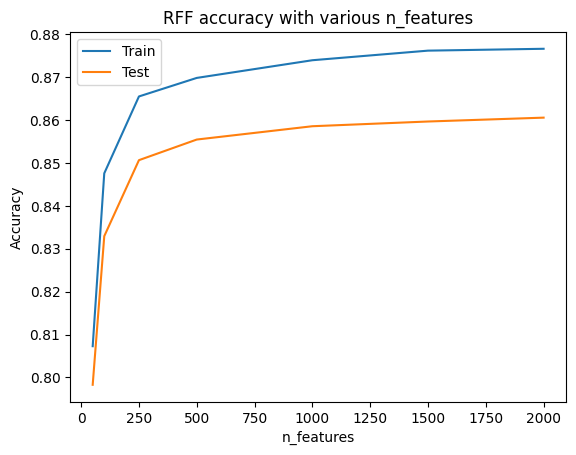

In [33]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_acc = []
test_acc = []

n_features_arr = [50, 100, 250, 500, 1000, 1500, 2000]

for n_features in n_features_arr:
    rff = RFFPipeline(n_features=n_features)
    rff.fit(x_train, y_train)

    train_acc.append(accuracy_score(y_train, rff.predict(x_train)))
    test_acc.append(accuracy_score(y_test, rff.predict(x_test)))

clear_output()
plt.plot(n_features_arr, train_acc, label="Train")
plt.plot(n_features_arr, test_acc, label="Test")
plt.title("RFF accuracy with various n_features")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.show()

Видно, что на плато модель выходит, после 1000, а минимальное адекватное качество (>0.85) достигается на 250. Скорее всего, там просто мало фичей, мы тут все же картинки классифицируем, 100 фичей - как-то несерьезно. А делать сильно больше исходной - бессмысленно, ничего нового там не будет, на 1000 как будто все возможные частоты косинуса и так переберем

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError